In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
"""data = pd.read_csv('/content/drive/MyDrive/ANN/Datasets/YearPredictionMSD.txt', header=None)
data = data.sample(frac = 1).reset_index(drop=True)
data.to_csv('/content/drive/MyDrive/ANN/Datasets/shuffled.csv', header=False, index = False)"""

"data = pd.read_csv('/content/drive/MyDrive/ANN/Datasets/YearPredictionMSD.txt', header=None)\ndata = data.sample(frac = 1).reset_index(drop=True)\ndata.to_csv('/content/drive/MyDrive/ANN/Datasets/shuffled.csv', header=False, index = False)"

In [3]:
data = pd.read_csv('/content/drive/MyDrive/ANN/Datasets/shuffled.csv', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,2007,47.85716,-22.54866,27.41759,-3.46676,12.55414,-10.22042,-9.18490,-7.13421,-9.53504,-5.93245,0.57714,-4.70568,61.66049,2867.48999,1944.08552,1784.42263,1207.38170,664.43034,577.79656,549.58769,456.81456,300.43874,246.92914,266.58839,223.80406,-863.28995,-74.21058,-76.36981,-65.16386,64.81949,-31.21618,7.72559,-15.13828,-64.63773,-13.14384,38.33320,-252.53327,-278.20472,-422.52063,...,26.36727,-18.91126,1.98145,25.16795,-149.99879,-50.90433,41.11608,8.05801,-210.68600,-42.75290,35.18520,-17.60934,13.65030,-338.55109,-30.58494,35.76208,11.35889,59.26721,86.69136,-19.56605,-139.79139,10.21379,0.14924,-34.07940,-51.48116,-46.05088,36.88103,20.17341,-171.02320,14.09129,37.80966,-158.87348,169.06257,59.61731,-2.20260,82.48771,-164.05115,9.64560,134.01159,10.97408
1,2003,52.08312,22.22323,19.70803,-6.34980,-22.01613,-23.59558,-4.43211,-5.20110,4.66203,3.11451,1.36996,1.41865,10.61272,1683.98949,750.69069,689.95647,581.29657,291.23380,283.81821,323.20547,279.78425,155.57909,167.29504,124.75346,41.95109,9.03560,-87.31790,-25.05778,-120.50192,6.26263,-23.86149,3.67036,12.61330,3.68605,-1.20386,-5.03250,-244.50791,-174.65006,-16.73915,...,36.12745,9.46506,-30.00579,26.49068,25.44980,-135.68219,24.69577,33.52959,1.27662,-85.21346,-29.57517,1.60170,-15.29097,-19.32349,-71.14568,42.22941,26.16730,14.61289,-19.89144,-2.31856,110.67443,76.66515,-15.62666,39.84537,-23.63016,8.16260,-60.59498,1.75061,-86.04602,34.42540,-10.07294,-7.06261,12.42736,39.77289,-0.41058,45.56069,48.57920,1.15398,64.40024,0.55140
2,2005,48.21072,-15.91816,2.07506,-13.89081,-4.34230,-15.00750,-11.66430,-9.04179,-0.18506,-8.89775,0.92205,12.65308,13.66445,1367.46906,624.89184,549.96749,451.94673,430.00000,370.69808,381.46521,309.08273,267.60033,133.98007,145.65567,47.79475,-237.57732,-79.39043,-19.00565,-55.21383,-3.16614,9.97518,0.36305,-22.70285,-41.40037,-6.87967,1.18909,-37.30190,-159.06320,-160.83604,...,22.64237,-58.49335,17.13903,3.30279,-0.64256,-54.53288,-47.29670,-116.28927,19.09955,-117.79150,-11.41164,-3.75067,-9.60609,-94.54838,6.55066,-12.86156,-13.46065,13.26680,34.09207,-11.55161,-109.55424,-20.87600,0.00377,-10.89014,-14.02785,-9.91583,184.98336,48.14045,-26.09251,5.60701,21.40159,-77.70125,8.67284,13.78993,4.16783,68.44852,-29.81270,4.65790,18.11617,1.87273
3,1982,37.23893,-61.57292,-8.41641,3.53303,-68.31349,4.12890,23.19388,0.57733,15.38495,-10.38546,4.05766,1.14463,26.52685,2025.06370,1954.59923,1183.20386,736.35195,705.35929,622.80910,392.36940,795.25798,410.57707,263.77880,292.14555,24.01719,380.65116,-645.27885,69.82662,-47.58921,33.14936,36.02033,5.85842,217.78312,-26.98982,-39.91616,30.04096,115.82088,-229.66297,-263.33341,...,66.50618,-193.93881,-13.73458,233.81607,-76.70293,2.76503,-86.71281,-67.09139,-32.43151,-113.89672,23.15733,-5.20699,28.66754,-526.18576,39.66235,-116.00312,-23.95451,26.51531,-133.47617,-61.43846,76.67006,284.78975,-67.73264,24.40962,-35.31231,-23.29012,630.24578,288.99653,54.73015,2.22204,82.27618,263.81035,-182.75213,-64.27024,13.62364,33.17791,107.14478,7.05733,240.23404,26.53820
4,2004,51.26551,11.37543,27.89572,0.44384,-11.08988,-20.47332,9.17345,-0.84317,3.19313,6.24197,-0.98135,-0.36932,10.40483,915.88236,1145.10263,486.84712,1048.51097,428.96277,420.32199,312.18948,258.36617,188.41523,175.19580,291.55670,-9.12916,95.24901,122.83992,180.79745,10.73693,48.69879,-2.70455,-6.76961,21.97340,-16.65634,54.78426,13.37456,-100.25554,423.67127,-113.89452,...,-50.31355,98.49313,-16.52861,-29.66221,-22.05528,-62.18155,84.55146,49.12364,6.13112,-11.46305,-52.60162,0.21349,-10.88931,-116.70456,-38.56895,45.48205,29.25824,27.11312,-73.54797,14.81368,-21.19950,116.54460,-0.09501,-7.28943,44.92769,5.01606,-126.21246,30.93915,-33.59216,-90.89191,0.32462,-93.78731,18.71632,-6.71576,5.38048,104.2

In [4]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,1998.397082,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,1.882385,-0.146527,2.546063,33.714006,2439.359375,1967.734202,1514.859902,910.981344,879.146721,603.737434,517.579339,393.962215,325.733170,288.885085,291.973238,43.031969,43.314873,-46.449006,-27.672783,14.958491,44.514859,5.131786,24.034309,9.498816,-4.178856,0.499475,72.652267,-51.441256,117.921056,-189.880885,...,6.378511,28.294082,12.772241,1.700474,-10.205155,64.101262,104.822085,-0.026481,38.678040,-27.989985,3.301739,0.307127,-0.478828,-138.223224,-0.696065,0.242582,3.151751,27.642745,31.822244,-0.835950,-8.931564,4.849253,-27.347646,-11.938792,-21.572137,-5.576196,-23.304324,31.113053,-104.974794,26.962393,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105
std,10.931046,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,6.530232,4.370848,8.320190,22.259632,1749.367690,1261.484792,1092.831044,475.708203,576.865994,317.499288,309.364735,214.013502,165.699383,186.960729,153.475649,121.429498,715.759147,544.879865,218.368476,163.215789,134.887832,99.088119,71.809934,74.411680,53.517036,42.490396,107.912629,415.039100,453.399231,260.645370,...,93.555672,75.049277,69.981849,83.278660,57.806591,273.827189,311.135298,266.774027,169.072163,144.083035,59.447204,49.181425,37.675424,308.187390,222.198519,128.140961,99.920949,116.696176,106.359938,36.799193,251.606754,229.060421,163.782620,63.288891,64.691545,26.358175,268.190912,144.156203,201.137522,123.847891,32.099635,175.618889,122.228799,95.050631,16.161764,114.427905,173.977336,13.346557,185.558247,22.088576
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,-41.631660,-69.680870,-94.041960,0.132830,8.474200,21.214350,17.857900,12.150420,5.517710,19.808810,6.254870,6.183760,15.307500,6.116440,5.177340,-2821.430210,-13390.360690,-12017.088870,-4324.864700,-3357.279900,-3115.374560,-3805.666170,-1516.356440,-1679.118320,-1590.637130,-989.645800,-1711.484000,-8448.194880,-10095.725950,-9803.759040,...,-2270.811070,-1746.478220,-3188.177380,-2199.782210,-1694.260320,-5154.024360,-5111.601750,-4730.599100,-3756.490790,-2499.954680,-1900.104800,-1396.701680,-600.090760,-10345.833280,-7375.977440,-3896.275220,-1199.004420,-2564.788120,-1904.984320,-974.702480,-7057.712450,-6953.357360,-8400.603300,-1812.889440,-1387.505490,-718.421050,-9831.453860,-2025.778160,-8390.035450,-4754.937170,-437.722030,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.

In [5]:
#scaler = StandardScaler()
#data = pd.DataFrame(scaler.fit_transform(data))
datanorm = (data-data.min())/(data.max()-data.min())
xdata = datanorm.drop(columns=0)
#xdata = data.drop(columns=0)
#xdata = pd.DataFrame(scaler.fit_transform(xdata))
#xdata = (xdata-xdata.min())/(xdata.max()-xdata.min())
ydata = datanorm.loc[:,0]
#ydata = data.loc[:,0]
#ydata = ((ydata-ydata.min())*10)/(ydata.max()-ydata.min())
xdata.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,0.765647,0.436165,0.526439,0.307613,0.438058,0.288568,0.496453,0.328087,0.428717,0.350071,0.445512,0.490980,0.111943,0.043498,0.052258,0.055497,0.060202,0.039159,0.046961,0.056813,0.046890,0.076926,0.035777,0.026653,0.625172,0.330791,0.450293,0.549222,0.496181,0.476894,0.613424,0.439127,0.364351,0.389189,0.348392,0.415870,0.362685,0.540765,0.591175,0.483764,...,0.621252,0.410650,0.571422,0.436239,0.682276,0.421417,0.289290,0.267240,0.386431,0.300016,0.521454,0.581956,0.434502,0.467760,0.716364,0.535426,0.371957,0.357277,0.276937,0.555245,0.628001,0.595455,0.798194,0.515176,0.501165,0.460701,0.497102,0.375447,0.605302,0.561725,0.371888,0.478312,0.394264,0.653495,0.563784,0.475980,0.580958,0.351250,0.511211,0.370423
1,0.835821,0.498248,0.514082,0.301729,0.360201,0.234643,0.509632,0.337789,0.480763,0.438787,0.450539,0.524638,0.019067,0.025492,0.019825,0.021114,0.028667,0.016980,0.022219,0.033142,0.028469,0.037844,0.023946,0.012192,0.587838,0.353826,0.449799,0.555855,0.487840,0.468113,0.614620,0.437958,0.370428,0.406614,0.352652,0.405563,0.363040,0.546469,0.616746,0.482981,...,0.623892,0.417395,0.565693,0.436498,0.759792,0.414416,0.288368,0.268676,0.409532,0.294831,0.504005,0.590063,0.414013,0.482682,0.712408,0.536307,0.376507,0.351197,0.262117,0.565272,0.650738,0.601137,0.796695,0.536586,0.511612,0.497848,0.492192,0.372066,0.611560,0.564121,0.334442,0.495424,0.363070,0.649388,0.566760,0.470574,0.610681,0.339110,0.506524,0.360584
2,0.771518,0.445359,0.485817,0.286338,0.400005,0.269268,0.489577,0.318512,0.462994,0.320993,0.447699,0.586381,0.024619,0.020676,0.016406,0.016716,0.022152,0.025227,0.029531,0.039233,0.031518,0.068066,0.018996,0.014323,0.589038,0.347314,0.450098,0.556638,0.497680,0.466699,0.620119,0.437005,0.362695,0.395116,0.350627,0.407042,0.372210,0.547328,0.607665,0.492043,...,0.620245,0.401241,0.574137,0.431952,0.748264,0.421117,0.284326,0.260227,0.411474,0.290854,0.508899,0.587804,0.418038,0.479166,0.719986,0.528805,0.364329,0.351014,0.269623,0.559904,0.630746,0.592796,0.798180,0.521892,0.515214,0.485460,0.504562,0.380579,0.615976,0.560726,0.359056,0.487461,0.362322,0.644011,0.574361,0.473924,0.599723,0.344119,0.503407,0.361832
3,0.589327,0.382051,0.469000,0.321900,0.255933,0.346421,0.586240,0.366790,0.520073,0.306404,0.467582,0.523132,0.048021,0.030681,0.052544,0.036610,0.036477,0.041592,0.050749,0.040374,0.082106,0.106640,0.038280,0.029258,0.584157,0.363639,0.428762,0.568121,0.498830,0.472145,0.624352,0.438589,0.415353,0.398791,0.338840,0.413899,0.378986,0.543439,0.601206,0.490588,...,0.632107,0.369045,0.568607,0.477148,0.714659,0.425849,0.282113,0.263002,0.405858,0.291329,0.518213,0.587189,0.445134,0.458990,0.723215,0.514760,0.361105,0.352818,0.246323,0.530904,0.647651,0.618934,0.791744,0.532116,0.507230,0.476296,0.526992,0.424778,0.621928,0.560327,0.406663,0.525955,0.324200,0.627858,0.590059,0.468761,0.618868,0.347550,0.518363,0.385116
4,0.822245,0.483206,0.527206,0.315595,0.384808,0.247231,0.547361,0.359661,0.475378,0.469455,0.435630,0.514812,0.018689,0.013806,0.030544,0.014733,0.052200,0.025165,0.033708,0.031990,0.026240,0.046703,0.025119,0.029198,0.577352,0.356102,0.457723,0.582467,0.507620,0.474476,0.618058,0.434950,0.372478,0.401426,0.372627,0.409938,0.369424,0.579426,0.610623,0.483382,...,0.600514,0.438557,0.568107,0.425488,0.738804,0.420485,0.291728,0.269556,0.410061,0.303836,0.497800,0.589477,0.417129,0.478130,0.715585,0.536750,0.377457,0.352899,0.254656,0.575231,0.638767,0.604547,0.798170,0.522935,0.537329,0.495692,0.488886,0.377423,0.615423,0.549360,0.342573,0.485648,0.364322,0.639768,0.576374,0.479170,0.588176,0.341346,0.510795,0.346954


In [6]:
x_train = xdata.loc[:round(0.7*data.shape[0]),:]
y_train = ydata.loc[:round(0.7*data.shape[0])]
x_val = xdata.loc[round(0.7*data.shape[0]):int(0.9*data.shape[0]),:]
y_val = ydata.loc[round(0.7*data.shape[0]):int(0.9*data.shape[0])]
x_test = xdata.loc[round(0.9*data.shape[0]):,:]
y_test = ydata.loc[round(0.9*data.shape[0]):]

print('Dataset Shapes:\n',x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

Dataset Shapes:
 (360743, 90) (360743,) (103069, 90) (103069,) (51535, 90) (51535,)


In [7]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
  def __init__(self, patience=0):
    super(EarlyStoppingCallback, self).__init__()
    self.patience = patience

  def on_train_begin(self, logs=None):
    self.best = np.Inf
    self.wait = 0
    self.stopped_epoch = 0

  def on_epoch_end(self, epoch, logs=None):
    current_loss = logs.get("val_mean_squared_error")
    if np.less(current_loss, self.best):
      self.best = current_loss
      self.wait = 0
      self.best_weights = self.model.get_weights()
    else:
      self.wait += 1
      if self.wait >= self.patience:
        self.stopped_epoch = epoch
        self.model.stop_training = True
        self.model.set_weights(self.best_weights)

  def on_train_end(self, logs=None):
    if self.stopped_epoch > 0:
      print("epoch: %d: early stopping" % self.stopped_epoch)

In [8]:
tf.keras.backend.clear_session()

reg_callback = EarlyStoppingCallback(patience=5)

def adapt_learning_rate(epoch):
    if epoch>5:
      return 0.0002 / (epoch-4)
    else:
      return 0.0002
  
my_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(adapt_learning_rate)

inp = tf.keras.Input(shape = 90, name="input")
hidden = tf.keras.layers.Dense(256)(inp)
hidden = tf.keras.layers.Dense(128)(hidden)
#hidden = tf.keras.layers.Dense(512)(hidden)
outp = tf.keras.layers.Dense(1)(hidden)

model = tf.keras.Model(inputs=inp, outputs=outp)

In [9]:
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(), metrics=['mean_squared_error'])
history = model.fit(x_train, y_train, epochs=1000, verbose=1, validation_data=(x_val,y_val), callbacks=[reg_callback, my_lr_scheduler])

Epoch 1/1000
11274/11274 [==============================] - 25s 2ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 2/1000
11274/11274 [==============================] - 24s 2ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 3/1000
11274/11274 [==============================] - 24s 2ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 4/1000
11274/11274 [==============================] - 24s 2ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0122 - val_mean_squared_error: 0.0122
Epoch 5/1000
11274/11274 [==============================] - 24s 2ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 6/1000
11274/11274 [==============================] - 24s 2ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0118 - val_mean_squared_

In [10]:
test_pred = np.round((model.predict(x_test) * (2011-1922)) + 1922)
#test_pred = np.round(model.predict(x_test))
#test_pred = np.round(model.predict(x_test))+1922
#test_pred = np.round(model.predict(x_test)*(9/10))+1922

In [11]:
ytestnotnorm = data.loc[round(0.9*data.shape[0]):,0].astype(int)
print(ytestnotnorm)
print(test_pred)
confmat = confusion_matrix(ytestnotnorm, test_pred, np.arange(1922,2012))
print(confmat)
df_confmat = pd.DataFrame(confmat, index = [i for i in np.arange(1922,2012)], columns = [i for i in np.arange(1922,2012)])

463810    2009
463811    2005
463812    2006
463813    1997
463814    1970
          ... 
515340    2008
515341    1991
515342    2005
515343    1991
515344    2004
Name: 0, Length: 51535, dtype: int64
[[2003.]
 [2001.]
 [2000.]
 ...
 [1995.]
 [1997.]
 [1999.]]
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ... 43 26 18]
 [ 0  0  0 ... 11 10  7]
 [ 0  0  0 ...  0  0  0]]


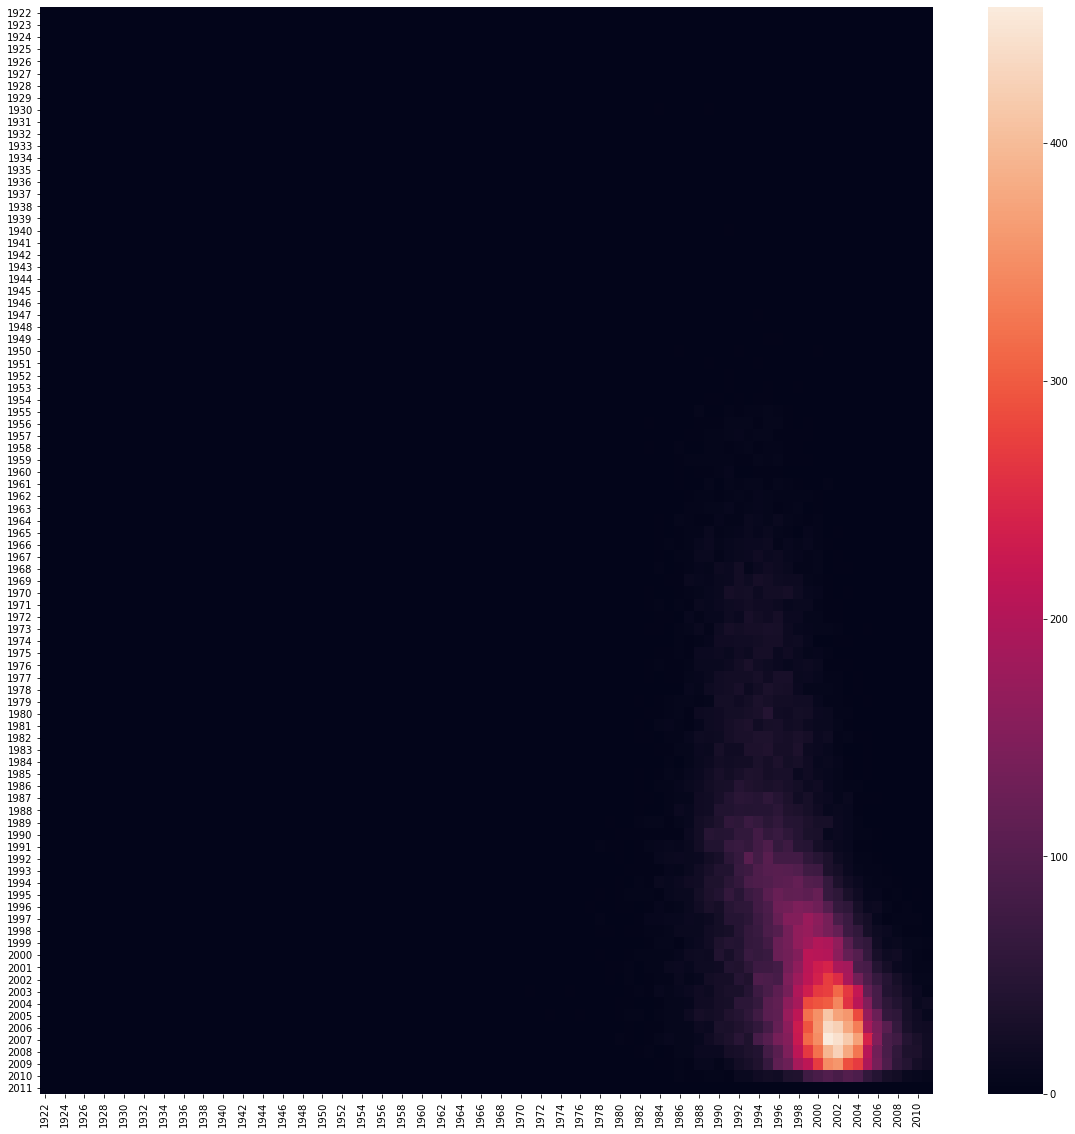

In [12]:
plt.figure(figsize = (20,20))
sn.heatmap(df_confmat)

In [13]:
accuracy_score(ytestnotnorm, test_pred)

0.055049966042495395

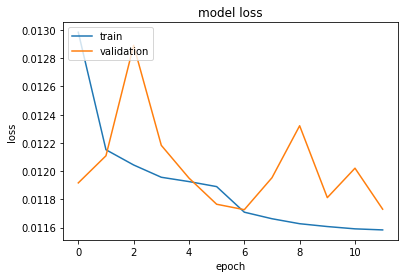

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

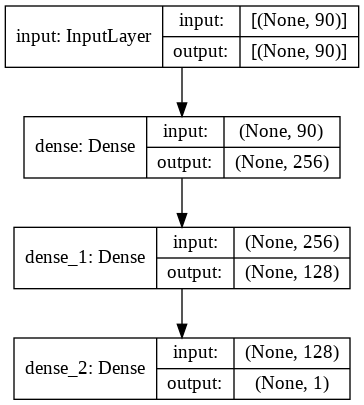

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)